<a href="https://colab.research.google.com/github/MathMachado/DSWP/blob/master/Notebooks/NB10_99__3DP_3_Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Melhorias da sessão**
* Mostrar junto os gráficos com a região de Anomaly Score junto com a distribuição de probabilidade das variáveis envolvidas.
* Mensagens de deprecating --> Analisar e substituir os métodos, funções deprecated;


___
# **Referências**
* [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)
* [Outlier detection with several methods](https://scikit-learn.org/0.18/auto_examples/covariance/plot_outlier_detection.html)

___
# **Agenda**

___
# **3DP_3_Anomaly Detection**
> Técnicas mais avançadas para detectarmos outliers.

## Carrega as Bibliotecas necessárias

In [1]:
!pip install pyod

     |████████████████████████████████| 92kB 5.4MB/s 
  Created wheel for pyod: filename=pyod-0.7.5-cp36-none-any.whl size=96597 sha256=fce6a3886e29171112fe251035d49592141f9277fd4e6ea2a788eb832c55c0dd
  Stored in directory: /root/.cache/pip/wheels/35/bc/f4/2cef321eac851ba02f533e3921b296bb4ce4998c8a4c9a8d6e
Successfully built pyod


In [0]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest

# Scaling variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from scipy import stats

## Carrega dataframe

In [0]:
df_Titanic = sns.load_dataset('titanic')
df_Titanic = df_Titanic.dropna()
df_Titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True


In [0]:
# Normalizar as variáveis 'age' e 'fare'
df_Titanic_Scaled= df_Titanic.copy()
df_Titanic_Scaled[['fare', 'age']]= StandardScaler().fit_transform(df_Titanic_Scaled[['fare','age']])

In [0]:
# Linhas do df_Titanic
df_Titanic_Scaled.shape

(182, 15)

In [0]:
# Descrever o dataframe, variável 'fare'
df_Titanic_Scaled['fare'].describe()

count    1.820000e+02
mean     2.537653e-16
std      1.002759e+00
min     -1.034601e+00
25%     -6.452479e-01
50%     -2.873576e-01
75%      1.452571e-01
max      5.681797e+00
Name: fare, dtype: float64

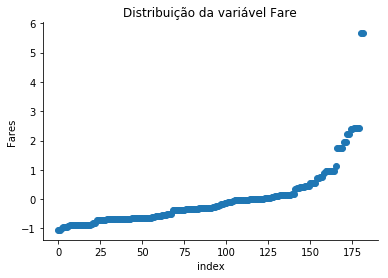

In [0]:
plt.scatter(range(df_Titanic_Scaled.shape[0]), np.sort(df_Titanic_Scaled['fare'].values))
plt.xlabel('index')
plt.ylabel('Fares')
plt.title("Distribuição da variável Fare")

sns.despine()

In [0]:
df_Titanic_Scaled.describe()

,survived,pclass,age,sibsp,parch,fare
count,182.000000,182.000000,1.820000e+02,182.000000,182.000000,1.820000e+02
mean,0.675824,1.192308,1.464030e-17,0.467033,0.478022,2.537653e-16
std,0.469357,0.516411,1.002759e+00,0.645007,0.755869,1.002759e+00
min,0.000000,1.000000,-2.220506e+00,0.000000,0.000000,-1.034601e+00
25%,0.000000,1.000000,-7.437173e-01,0.000000,0.000000,-6.452479e-01
50%,1.000000,1.000000,2.411064e-02,0.000000,0.000000,-2.873576e-01
75%,1.000000,1.000000,7.759421e-01,1.000000,1.000000,1.452571e-01
max,1.000000,3.000000,2.839480e+00,3.000000,4.000000,5.681797e+00


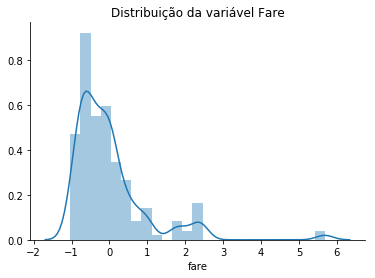

In [0]:
# Distribuição da variável 'fare'

sns.distplot(df_Titanic_Scaled['fare'])
plt.title("Distribuição da variável Fare")
sns.despine()

___
# **Kurtosis**
> Kurtosis é uma medida estatística que define com que intensidade as caudas de uma distribuição diferem das caudas de uma distribuição Normal. Em outras palavras, a curtose identifica se as caudas de uma determinada distribuição contêm valores extremos.
>> A Kurtosis de uma distribuição Normal padrão é igual a 3. Portanto, se Kurtosis-3 > 0, então isso é o que chamamos de excesso de Kurtosis.
>>> **Alta Kurtosis é um indicador de que os dados possuem caudas pesadas ou outliers**.

* **Dica muito importante**: Normalize os dados antes!

___
# **Skewness**
> É o grau de distorção da distribuição, ou seja, mede a falta de simetria na distribuição de dados, diferenciando valores extremos em uma cauda versus na outra. Uma distribuição simétrica terá uma assimetria de 0.

![Skewness](https://github.com/MathMachado/Python_RFB/blob/DS_Python/Material/Skewness.png?raw=true)

Source: [Skew and Kurtosis: 2 Important Statistics terms you need to know in Data Science](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

## Interpretando a Skewness (Rule of Thumb)
* Se -0.5 < Skewness < 0.5: Dados razoavelmente simétricos;
* Se -1 < Skewness < -0.5: Dados moderadamente negativa;
* Se 0.5 < Skewness < 1: Dados moderadamente positiva;
* Se Skewness < -1: Dados altamente negativa;
* Se Skewness > 1: Dados altamente positiva.

> **Dica**: Normalize os dados antes!

In [0]:
# Cálculo das medidas de Skewness e Kurtosis para 'fare'
print(f"Skewness: {df_Titanic_Scaled['fare'].skew()}")
print(f"Kurtosis: {df_Titanic_Scaled['fare'].kurt()}")

Skewness: 2.7073683146429004
Kurtosis: 10.690697893681472


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

In [0]:
# Distribuição da variável 'age'
df_Titanic_Scaled['age'].describe()

count    1.820000e+02
mean     1.464030e-17
std      1.002759e+00
min     -2.220506e+00
25%     -7.437173e-01
50%      2.411064e-02
75%      7.759421e-01
max      2.839480e+00
Name: age, dtype: float64

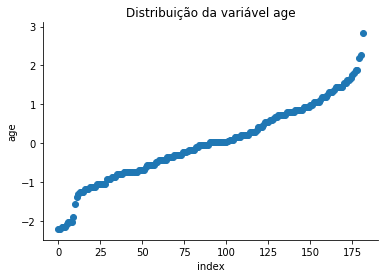

In [0]:
plt.scatter(range(df_Titanic_Scaled.shape[0]), np.sort(df_Titanic_Scaled['age'].values))
plt.xlabel('index')
plt.ylabel('age')
plt.title("Distribuição da variável age")
sns.despine()

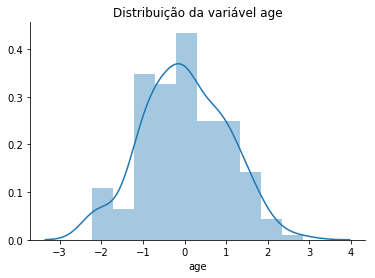

In [0]:
sns.distplot(df_Titanic_Scaled['age'])
plt.title("Distribuição da variável age")
sns.despine()

In [0]:
# Cálculo das medidas de Skewness e Kurtosis para 'age'
print(f"Skewness: {df_Titanic_Scaled['age'].skew()}")
print(f"Kurtosis: {df_Titanic_Scaled['age'].kurt()}")

Skewness: 0.01841894050949496
Kurtosis: -0.2309427735598728


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

___
# **Isolation Forest Region**

## Anomaly Detection para 'fare'

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


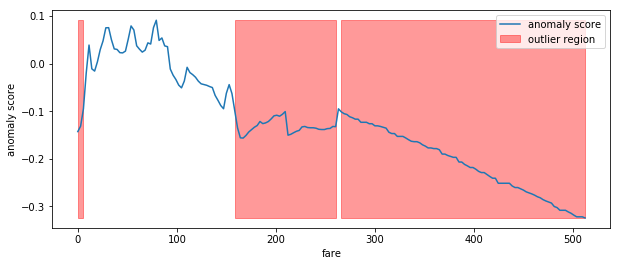

In [0]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df_Titanic['fare'].values.reshape(-1, 1))
xx = np.linspace(df_Titanic['fare'].min(), df_Titanic['fare'].max(), len(df_Titanic)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('fare')
plt.show();

In [0]:
# Vamos avaliar os dados do dataframe para fare > 200, por exemplo
df_Titanic.loc[df_Titanic['fare'] > 200].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
27,0,1,male,19.0,3,2,263.0000,S,First,man,True,C,Southampton,no,False
88,1,1,female,23.0,3,2,263.0000,S,First,woman,False,C,Southampton,yes,False
118,0,1,male,24.0,0,1,247.5208,C,First,man,True,B,Cherbourg,no,False
299,1,1,female,50.0,0,1,247.5208,C,First,woman,False,B,Cherbourg,yes,False
311,1,1,female,18.0,2,2,262.3750,C,First,woman,False,B,Cherbourg,yes,False


In [0]:
# Zoom na linha 27
df_Titanic.loc[27]

survived                 0
pclass                   1
sex                   male
age                     19
sibsp                    3
parch                    2
fare                   263
embarked                 S
class                First
who                    man
adult_male            True
deck                     C
embark_town    Southampton
alive                   no
alone                False
Name: 27, dtype: object

A região onde os dados têm baixa probabilidade de aparecer fica no lado direito da distribuição.

## Anomaly Detection para 'age'

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


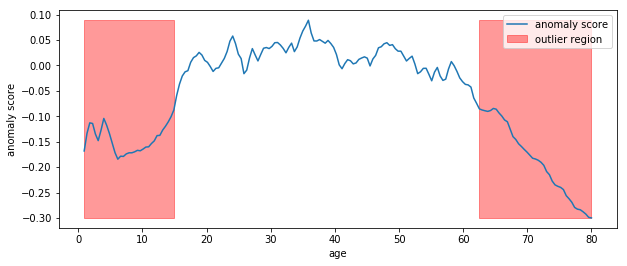

In [0]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df_Titanic['age'].values.reshape(-1, 1))
xx = np.linspace(df_Titanic['age'].min(), df_Titanic['age'].max(), len(df_Titanic)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('age')
plt.show();

Observe no gráfico acima que há duas regiões em que os dados têm baixa probabilidade de aparecer: uma no lado esquerdo da distribuição, outra no lado direito da distribuição.

In [0]:
# Avaliando os dados da cauda esquerda
df_Titanic.loc[df_Titanic['age'] < 15].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
183,1,2,male,1.0,2,1,39.0000,S,Second,child,False,F,Southampton,yes,False
193,1,2,male,3.0,1,1,26.0000,S,Second,child,False,F,Southampton,yes,False
205,0,3,female,2.0,0,1,10.4625,S,Third,child,False,G,Southampton,no,False
297,0,1,female,2.0,1,2,151.5500,S,First,child,False,C,Southampton,no,False


In [0]:
# Zoom na linha 3
df_Titanic.loc[10]

survived                 1
pclass                   3
sex                 female
age                      4
sibsp                    1
parch                    1
fare                  16.7
embarked                 S
class                Third
who                  child
adult_male           False
deck                     G
embark_town    Southampton
alive                  yes
alone                False
Name: 10, dtype: object

In [0]:
# Avaliando dados da cauda direita
df_Titanic.loc[df_Titanic['age'] > 65].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
96,0,1,male,71.0,0,0,34.6542,C,First,man,True,A,Cherbourg,no,True
630,1,1,male,80.0,0,0,30.0000,S,First,man,True,A,Southampton,yes,True
745,0,1,male,70.0,1,1,71.0000,S,First,man,True,B,Southampton,no,False


In [0]:
# Zoom na linha 96
df_Titanic.loc[96]

survived               0
pclass                 1
sex                 male
age                   71
sibsp                  0
parch                  0
fare             34.6542
embarked               C
class              First
who                  man
adult_male          True
deck                   A
embark_town    Cherbourg
alive                 no
alone               True
Name: 96, dtype: object

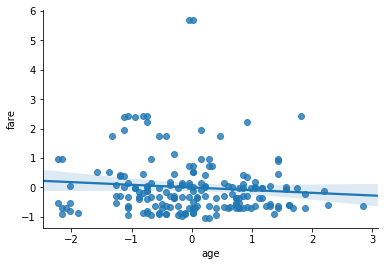

In [0]:
sns.regplot(x="age", y="fare", data=df_Titanic_Scaled)
sns.despine()

In [0]:
cols = ['fare', 'age']
df_Titanic_Scaled[cols].head()

,fare,age
1,-0.100110,0.152082
3,-0.338485,-0.039875
6,-0.354708,1.175852
10,-0.815672,-2.023430
11,-0.686543,1.431795


___
# **CBLOF - Cluster-based Local Outlier Factor**

In [0]:
# Normalizar as variáveis 'age' e 'fare'
df_Titanic_Scaled= df_Titanic.copy()
df_Titanic_Scaled[['fare', 'age']]= MinMaxScaler().fit_transform(df_Titanic_Scaled[['fare','age']])

In [0]:
X1 = df_Titanic_Scaled['age'].values.reshape(-1,1)
X2 = df_Titanic_Scaled['fare'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

OUTLIERS: 2 INLIERS: 180


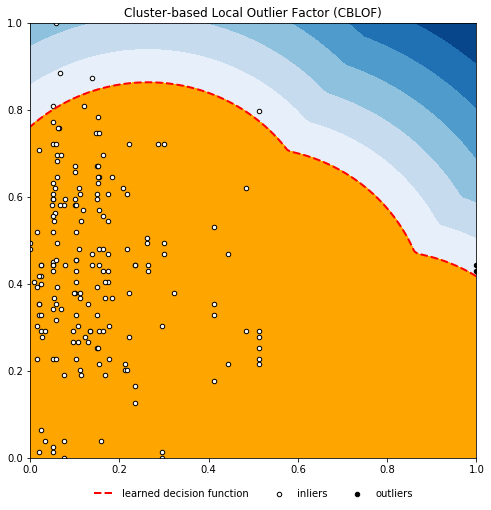

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df_Titanic_Scaled
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold para definir um ponto como inlier ou outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly Score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# Desenha a linha vermelha a partir do qual Anomaly Score = thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# Região Azul onde threshold < Anomaly Score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

In [0]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.443601,0,1,1.0,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.430956,0,0,1.0,C,First,man,True,B,Cherbourg,yes,True,1


In [0]:
# Zoom na linha 679
df_Titanic.loc[679]

survived               1
pclass                 1
sex                 male
age                   36
sibsp                  0
parch                  1
fare             512.329
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                yes
alone              False
Name: 679, dtype: object

In [0]:
# Algumas medidas para compararmos
df_Resumo = df_Titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_Resumo

,age,fare
,mean,mean
sex,,
female,33.0,89.0
male,38.0,69.0


In [0]:
# Média Geral de 'age'
round(df_Titanic['age'].mean())

36

In [0]:
# Média Geral de 'fare'
round(df_Titanic['fare'].mean())

79

___
# **HBOS - Histogram-based Outlier Detection**

OUTLIERS: 2 INLIERS: 180


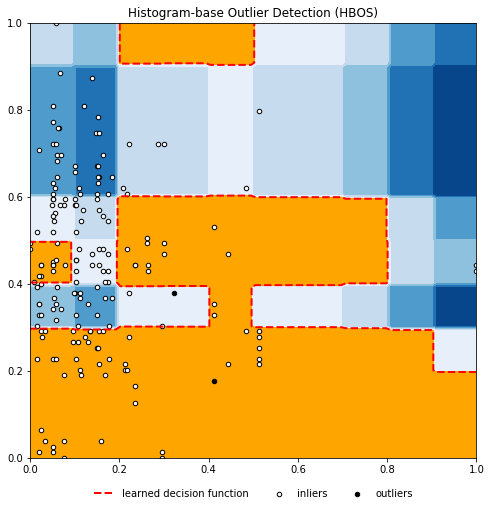

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df_Titanic_Scaled
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# threshold define se um ponto será outlier ou inlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# Define a região azul tal que min(Anomaly score) < threshold
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# Desenha a linha a partir do queal Anomaly score = thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# Define a região laranja a partir do qual threshold < Anomaly score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

In [0]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
318,1,1,female,0.380374,0,2,0.321798,S,First,woman,False,C,Southampton,yes,False,1
689,1,1,female,0.178048,0,1,0.412503,S,First,child,False,B,Southampton,yes,False,1


In [0]:
# Zoom na linha 689
df_Titanic.loc[689]

survived                 1
pclass                   1
sex                 female
age                     15
sibsp                    0
parch                    1
fare               211.338
embarked                 S
class                First
who                  child
adult_male           False
deck                     B
embark_town    Southampton
alive                  yes
alone                False
Name: 689, dtype: object

In [0]:
# Algumas medidas para compararmos
df_Resumo = df_Titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_Resumo

,age,fare
,mean,mean
sex,,
female,33.0,89.0
male,38.0,69.0


In [0]:
# Média Geral de 'age'
round(df_Titanic['age'].mean())

36

In [0]:
# Média Geral de 'fare'
round(df_Titanic['fare'].mean())

79

___
# **Isolation Forest**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


OUTLIERS:  2 INLIERS:  180


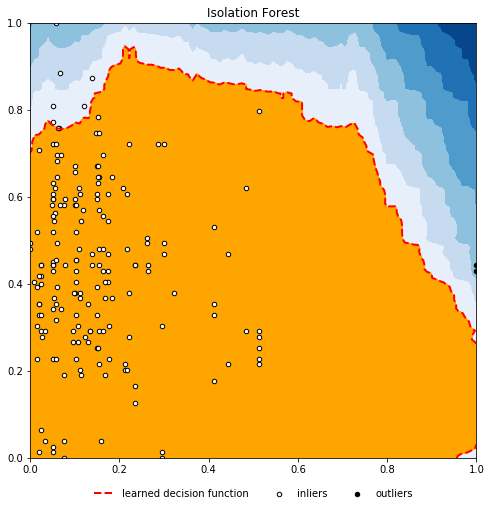

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df_Titanic_Scaled
df1['outlier'] = y_pred.tolist()
    
# fare - inlier feature 1,  age - inlier feature 2
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
# fare - outlier feature 1, age - outlier feature 2
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [0]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.443601,0,1,1.0,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.430956,0,0,1.0,C,First,man,True,B,Cherbourg,yes,True,1


In [0]:
# Zoom na linha 679
df_Titanic.loc[679]

survived               1
pclass                 1
sex                 male
age                   36
sibsp                  0
parch                  1
fare             512.329
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                yes
alone              False
Name: 679, dtype: object

In [0]:
# Algumas medidas para compararmos
df_Resumo = df_Titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_Resumo

,age,fare
,mean,mean
sex,,
female,33.0,89.0
male,38.0,69.0


In [0]:
# Média Geral de 'age'
round(df_Titanic['age'].mean())

36

In [0]:
# Média Geral de 'fare'
round(df_Titanic['fare'].mean())

79

___
# **KNN - K-Nearest Neighbors**

OUTLIERS:  2 INLIERS:  180


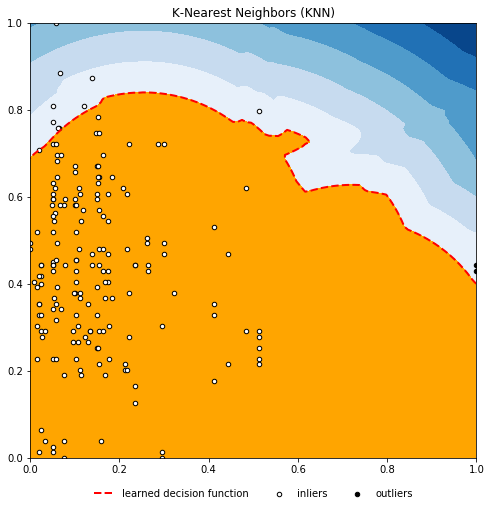

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df_Titanic_Scaled
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K-Nearest Neighbors (KNN)')
plt.show();

In [0]:
df1.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
1,1,1,female,0.468892,1,0,0.139136,C,First,woman,False,C,Cherbourg,yes,False,0
3,1,1,female,0.430956,1,0,0.103644,S,First,woman,False,C,Southampton,yes,False,0
6,0,1,male,0.671219,0,0,0.101229,S,First,man,True,E,Southampton,no,True,0
10,1,3,female,0.038948,1,1,0.032596,S,Third,child,False,G,Southampton,yes,False,0
11,1,1,female,0.721801,0,0,0.051822,S,First,woman,False,C,Southampton,yes,True,0


In [0]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.443601,0,1,1.0,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.430956,0,0,1.0,C,First,man,True,B,Cherbourg,yes,True,1


In [0]:
# Zoom na linha 679
df_Titanic.loc[679]

survived               1
pclass                 1
sex                 male
age                   36
sibsp                  0
parch                  1
fare             512.329
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                yes
alone              False
Name: 679, dtype: object

In [0]:
# Algumas medidas para compararmos
df_Resumo = df_Titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_Resumo

,age,fare
,mean,mean
sex,,
female,33.0,89.0
male,38.0,69.0


In [0]:
# Média Geral de 'age'
round(df_Titanic['age'].mean())

36

In [0]:
# Média Geral de 'fare'
round(df_Titanic['fare'].mean())

79